In [1]:
from core.manipulation_set import FrequencyManipulationSet, RGBManipulationSet
from utils import feature_visualisation, read_target_image

import hydra
from hydra import compose, initialize
import torch
import torch.multiprocessing

import matplotlib.pyplot as plt
import random

torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=8)

In [2]:
with initialize(version_base=None, config_path="../config"):
    cfg = compose(
        config_name="config",
        overrides=[],
    )
torch.multiprocessing.set_sharing_strategy("file_system")

In [3]:
class VisualizationUnit(torch.nn.Module):
    def __init__(
        self, norm_target, n_channels, image_dims, filter_dim=None, out_channels=1
    ):
        super(VisualizationUnit, self).__init__()

        filter_dim = filter_dim or image_dims
        self.out_channels = out_channels
        self.filter_dim = filter_dim
        self.image_dims = image_dims
        self.norm_target_shape = norm_target.shape

        # Define a single Conv2d layer (no training required)
        self.conv = torch.nn.Conv2d(
            in_channels=n_channels,
            out_channels=out_channels,  # Single output
            kernel_size=filter_dim,
            # Kernel size matches the input spatial dimensions
            stride=1,
            padding=0,
            bias=False,  # No bias for simplicity
        )
        self.relu = torch.nn.ReLU()

        # Set weights directly from norm_target
        with torch.no_grad():
            for n in range(self.out_channels):
                # find a subimage of the target images in the size of the kernel
                rand_x = random.randint(0, self.norm_target_shape[2] - self.filter_dim)
                rand_y = random.randint(0, self.norm_target_shape[3] - self.filter_dim)
                subimage = norm_target[
                    :,
                    :,
                    rand_x : rand_x + self.filter_dim,
                    rand_y : rand_y + self.filter_dim,
                ]
                self.conv.weight[n].copy_(
                    subimage[0]
                )  # Add batch and out_channels dimensions

            self.max = self.conv(norm_target).item()

    def forward(self, x):
        # Apply the convolution
        return -self.relu(-self.conv(x) + self.max)

In [ ]:
device = cfg.device
dataset = cfg.data
image_dims = int(cfg.data.image_dims)
n_channels = int(cfg.data.n_channels)
fv_sd = float(cfg.fv_sd)
fv_dist = cfg.fv_dist
fv_domain = cfg.fv_domain
target_img_path = "." + cfg.target_img_path
zero_rate = cfg.get("zero_rate", 0.5)
tunnel = cfg.get("tunnel", False)
target_noise = float(cfg.get("target_noise", 0.0))

transforms = hydra.utils.instantiate(dataset.fv_transforms)
normalize = hydra.utils.instantiate(cfg.data.normalize)
denormalize = hydra.utils.instantiate(cfg.data.denormalize)
resize_transforms = hydra.utils.instantiate(cfg.data.resize_transforms)

default_model = hydra.utils.instantiate(cfg.model.model)
default_model.to(device)

In [ ]:
noise_ds_type = FrequencyManipulationSet if fv_domain == "freq" else RGBManipulationSet
noise_dataset = noise_ds_type(
    image_dims,
    target_img_path,
    normalize,
    denormalize,
    transforms,
    resize_transforms,
    n_channels,
    fv_sd,
    fv_dist,
    zero_rate,
    tunnel,
    target_noise,
    device,
)

In [6]:
norm_target, _ = read_target_image(device, n_channels, target_img_path, normalize)
# create conv layer encoding norm_target
model = VisualizationUnit(norm_target.to("cpu"), n_channels, image_dims, 128, 1)

model.to(device)

model.eval()

RuntimeError: a Tensor with 9409 elements cannot be converted to Scalar

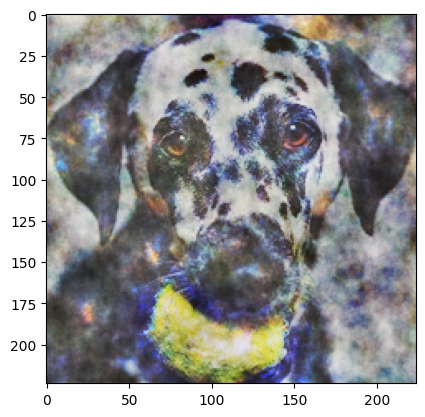

In [36]:
img, _, tstart = feature_visualisation(
    net=model,
    noise_dataset=noise_dataset,
    man_index=0,
    lr=0.001,
    n_steps=100,
    init_mean=torch.tensor([]),
    # save_list=[1,5,10,20,50,100,2000],
    # tf = torchvision.transforms.Compose(transforms),
    grad_clip=True,
    adam=True,
    device=device,
)
plt.imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())
plt.show()

In [43]:
kernel_size = 164
conv = torch.nn.Conv2d(
    in_channels=n_channels,
    out_channels=2,  # Single output
    kernel_size=kernel_size,
    # Kernel size matches the input spatial dimensions
    stride=1,
    padding=0,
    bias=False,  # No bias for simplicity
)
for n in range(2):
    # find a subimage of the target images in the size of the kernel
    rand_x = random.randint(0, norm_target.shape[2] - kernel_size)
    rand_y = random.randint(0, norm_target.shape[3] - kernel_size)
    subimage = norm_target[
        :, :, rand_x : rand_x + kernel_size, rand_y : rand_y + kernel_size
    ]
    conv.weight.data[n] = subimage

conv(norm_target.to("cpu")).shape

torch.Size([1, 2, 61, 61])

In [46]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  